In [2]:
# COE379L Project 4 - Exploring Neural Network Architecture Search on Clean vs Noisy Image Data
# Ayushi Sapru (as98489)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 MB 153.3 MB/s eta 0:00:00a 0:00:01


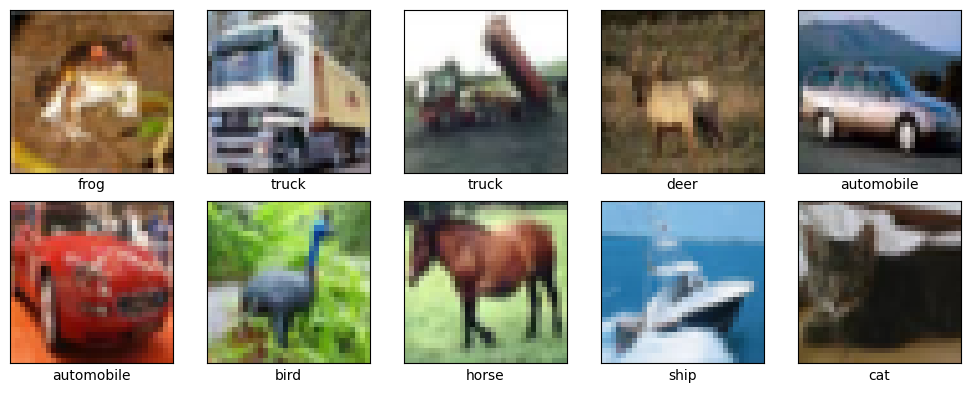

In [8]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
!pip install opencv-python-headless

# ChatGPT helped me write the following lines to ignore all warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  
import warnings
warnings.filterwarnings('ignore')  

# Load CIFAR-10
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Labels for CIFAR-10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Show sample images
plt.figure(figsize = (10, 4))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i])
    plt.xlabel(class_names[y_train[i][0]])
plt.tight_layout()
plt.show()

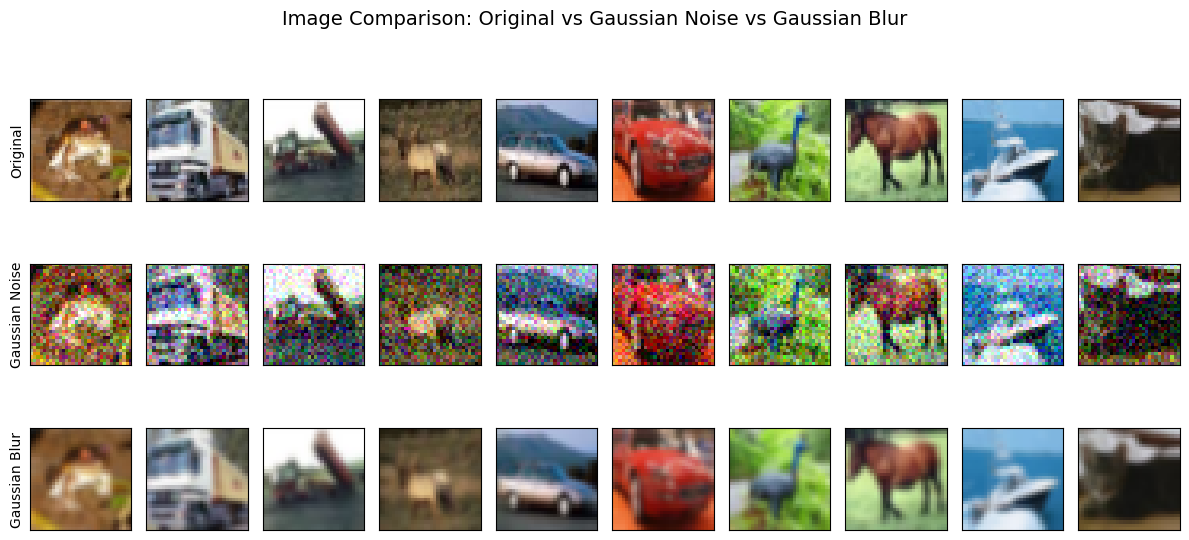

In [13]:
# We've successfully loaded the CIFAR-10 data, normalized the pixel values, and displayed a few sample images.
# Now, we will apply Gaussian noise using cv2 and compare it to other noises later. 

import cv2
from skimage.util import random_noise

def add_gaussian_noise(images, var = 0.02):
    noisy_imgs = []
    for img in images:
        noisy = random_noise(img, mode = 'gaussian', var = var)
        noisy_imgs.append(noisy)
    return np.clip(np.array(noisy_imgs), 0., 1.)

x_train_gauss = add_gaussian_noise(x_train, var = 0.02)
x_test_gauss = add_gaussian_noise(x_test, var = 0.02)

def add_blur(images, ksize = 3):
    blurred_imgs = []
    for img in images:
        img_uint8 = (img * 255).astype(np.uint8)
        blurred = cv2.GaussianBlur(img_uint8, (ksize, ksize), 0)
        blurred = blurred.astype(np.float32) / 255.0
        blurred_imgs.append(blurred)
    return np.array(blurred_imgs)

x_train_blur = add_blur(x_train, ksize = 3)
x_test_blur = add_blur(x_test, ksize = 3)

# Compare original, noisy, and blurred.
plt.figure(figsize = (12, 6))
for i in range(10):
    plt.subplot(3, 10, i + 1)
    plt.xticks([]); plt.yticks([])
    plt.imshow(x_train[i])
    if i == 0:
        plt.ylabel("Original", fontsize = 10)
    
    plt.subplot(3, 10, i + 11)
    plt.xticks([]); plt.yticks([])
    plt.imshow(x_train_gauss[i])
    if i == 0:
        plt.ylabel("Gaussian Noise", fontsize = 10)
    
    plt.subplot(3, 10, i + 21)
    plt.xticks([]); plt.yticks([])
    plt.imshow(x_train_blur[i])
    if i == 0:
        plt.ylabel("Gaussian Blur", fontsize = 10)

plt.suptitle("Image Comparison: Original vs Gaussian Noise vs Gaussian Blur", fontsize = 14)
plt.tight_layout()
plt.show()

In [14]:
# Gaussian noise introduces random pixel-level variation that significantly distorts fine detail, while Gaussian blur smooths and 
# softens edges. Both distortions reduce visual clarity in different ways, and will likely challenge CNNs in distinct architectural 
# dimensions.

# Next, we will apply JPEG compression and compare. 

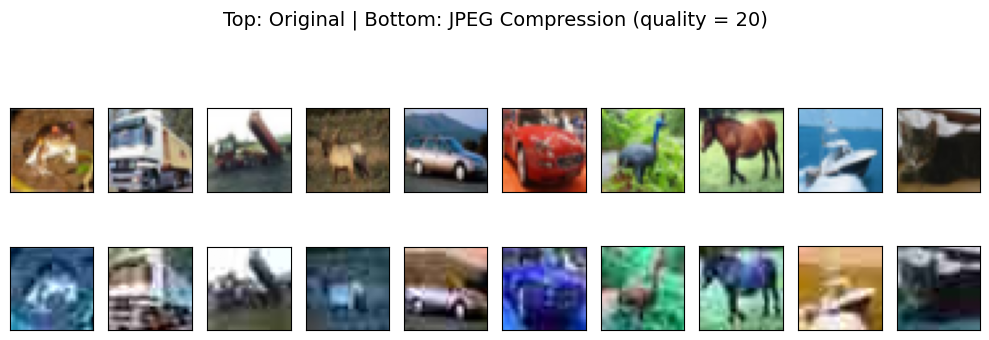

In [15]:
def add_jpeg_compression(images, quality = 20):
    jpeg_imgs = []
    for img in images:
        img_uint8 = (img * 255).astype(np.uint8)
        encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), quality]
        success, encoded_img = cv2.imencode('.jpg', img_uint8, encode_param)
        decoded_img = cv2.imdecode(encoded_img, cv2.IMREAD_COLOR)
        decoded_img = cv2.cvtColor(decoded_img, cv2.COLOR_BGR2RGB) / 255.0
        jpeg_imgs.append(decoded_img)
    return np.array(jpeg_imgs)

x_train_jpeg = add_jpeg_compression(x_train, quality = 20)
x_test_jpeg = add_jpeg_compression(x_test, quality = 20)

plt.figure(figsize = (10, 4))
for i in range(10):
    plt.subplot(2, 10, i + 1)
    plt.imshow(x_train[i])
    plt.xticks([]); plt.yticks([])
    plt.subplot(2, 10, i + 11)
    plt.imshow(x_train_jpeg[i])
    plt.xticks([]); plt.yticks([])
    
plt.suptitle("Top: Original | Bottom: JPEG Compression (quality = 20)", fontsize = 14)
plt.tight_layout()
plt.show()

In [16]:
# JPEG compression introduced blockiness and color bleeding, especially in areas with flat textures or sharp transitions. 
# Unlike noise or blur, this distortion reflects a common real-world scenario from image saving or transmission, potentially affecting 
# generalization in a different way.

# Next, let's apply Salt-and-Pepper Noise and view how it compares to the original images. 

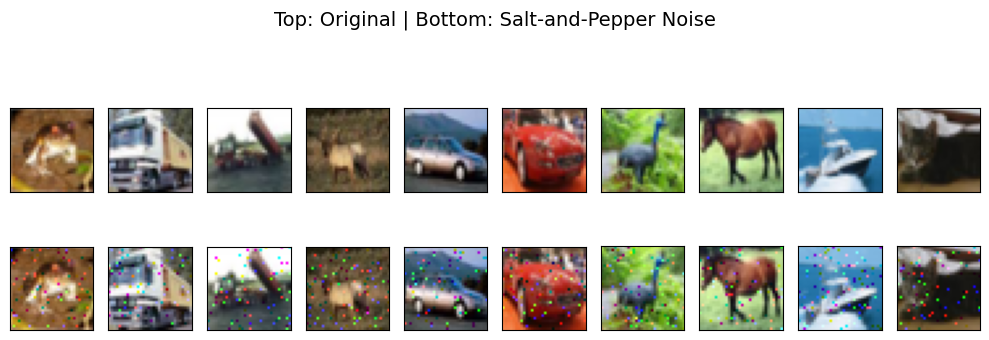

In [17]:
def add_salt_pepper_noise(images, amount = 0.02):
    noisy_imgs = []
    for img in images:
        noisy = random_noise(img, mode = 's&p', amount = amount)
        noisy_imgs.append(noisy)
    return np.clip(np.array(noisy_imgs), 0., 1.)

x_train_sp = add_salt_pepper_noise(x_train, amount = 0.03)
x_test_sp = add_salt_pepper_noise(x_test, amount = 0.03)

plt.figure(figsize = (10, 4))
for i in range(10):
    plt.subplot(2, 10, i + 1)
    plt.imshow(x_train[i])
    plt.xticks([]); plt.yticks([])

    plt.subplot(2, 10, i + 11)
    plt.imshow(x_train_sp[i])
    plt.xticks([]); plt.yticks([])
    
plt.suptitle("Top: Original | Bottom: Salt-and-Pepper Noise", fontsize = 14)
plt.tight_layout()
plt.show()

In [18]:
# Salt-and-pepper noise randomly flips pixels to extreme black or white values, creating sparse but harsh disruptions. It presents
# a different challenge compared to Gaussian noise or blur, likely requiring architectures that are robust to localized, high-contrast 
# corruption.

# Since we've applied all the noises to the CIFAR-10 dataset, let's save all of them. 

In [19]:
os.makedirs("data/noisy", exist_ok = True)

np.save("data/noisy/x_train_gauss.npy", x_train_gauss)
np.save("data/noisy/x_test_gauss.npy", x_test_gauss)

np.save("data/noisy/x_train_blur.npy", x_train_blur)
np.save("data/noisy/x_test_blur.npy", x_test_blur)

np.save("data/noisy/x_train_jpeg.npy", x_train_jpeg)
np.save("data/noisy/x_test_jpeg.npy", x_test_jpeg)

np.save("data/noisy/x_train_sp.npy", x_train_sp)
np.save("data/noisy/x_test_sp.npy", x_test_sp)

np.save("data/y_train.npy", y_train)
np.save("data/y_test.npy", y_test)

In [23]:
# Let’s start with Keras Tuner. 

!pip install keras-tuner --quiet

from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt

def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Input(shape = (32, 32, 3)))
    
    for i in range(hp.Int('conv_blocks', 1, 3)):
        model.add(layers.Conv2D(
            filters = hp.Int(f'filters_{i}', min_value = 32, max_value = 128, step = 32),
            kernel_size = hp.Choice(f'kernel_size_{i}', values = [3, 5]),
            activation = 'relu'))
        model.add(layers.MaxPooling2D())
    
    model.add(layers.Flatten())
    model.add(layers.Dense(
        hp.Int('dense_units', 64, 256, step=64),
        activation = 'relu'))
    model.add(layers.Dropout(hp.Float('dropout', 0.2, 0.5, step = 0.1)))
    model.add(layers.Dense(10, activation = 'softmax'))

    model.compile(
        optimizer = keras.optimizers.Adam(
            hp.Float('learning_rate', 1e-4, 1e-2, sampling = 'log')), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy']
    )
    return model

tuner = kt.RandomSearch(
    build_model,
    objective = 'val_accuracy',
    max_trials = 10,
    executions_per_trial = 1,
    directory = 'tuner_results',
    project_name = 'cifar_clean'
)

tuner.search(x_train, y_train,
             epochs = 5,
             validation_split = 0.2,
             verbose = 2)

Trial 10 Complete [00h 00m 52s]
val_accuracy: 0.5476999878883362

Best val_accuracy So Far: 0.6621999740600586
Total elapsed time: 00h 17m 34s


In [26]:
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()
test_loss, test_acc = best_model.evaluate(x_test, y_test)
print(f"Clean Test Accuracy: {test_acc:.4f}")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 96)        2688      
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 96)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 128)       110720    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 128)         0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 256)               1

In [24]:
tuner = kt.RandomSearch(
    build_model,
    objective = 'val_accuracy',
    max_trials = 10,
    executions_per_trial = 1,
    directory = 'tuner_results',
    project_name = 'cifar_gauss'  
)

tuner.search(x_train_gauss, y_train,
             epochs = 5,
             validation_split = 0.2,
             verbose = 2)

best_model = tuner.get_best_models(1)[0]
test_loss, test_acc = best_model.evaluate(x_test_gauss, y_test)
print("Gaussian Noise Test Accuracy:", test_acc)

Trial 10 Complete [00h 05m 18s]
val_accuracy: 0.09969999641180038

Best val_accuracy So Far: 0.602400004863739
Total elapsed time: 00h 22m 14s
313/313 [==============================] - 2s 7ms/step - loss: 1.1167 - accuracy: 0.6086
Gaussian Noise Test Accuracy: 0.6086000204086304


In [29]:
tuner = kt.RandomSearch(
    build_model,
    objective = 'val_accuracy',
    max_trials = 10,
    executions_per_trial = 1,
    directory = 'tuner_results',
    project_name = 'cifar_blur'
)

tuner.search(x_train_blur, y_train,
             epochs = 5,
             validation_split = 0.2,
             verbose = 2)

best_model = tuner.get_best_models(1)[0]
best_model.summary()
test_loss, test_acc = best_model.evaluate(x_test_blur, y_test)
print("Gaussian Blur Test Accuracy:", test_acc)

Trial 10 Complete [00h 01m 35s]
val_accuracy: 0.5916000008583069

Best val_accuracy So Far: 0.6107000112533569
Total elapsed time: 00h 20m 04s
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 96)        153696    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 96)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 2400)    

In [31]:
tuner = kt.RandomSearch(
    build_model,
    objective = 'val_accuracy',
    max_trials = 10,
    executions_per_trial = 1,
    directory = 'tuner_results',
    project_name = 'cifar_jpeg'
)

tuner.search(
    x_train_jpeg, y_train,
    epochs = 5,
    validation_split = 0.2,
    verbose = 2
)

best_model = tuner.get_best_models(1)[0]
best_model.summary()
test_loss, test_acc = best_model.evaluate(x_test_jpeg, y_test)
print("JPEG Compression Test Accuracy:", test_acc)

Trial 10 Complete [00h 01m 26s]
val_accuracy: 0.625

Best val_accuracy So Far: 0.625
Total elapsed time: 00h 19m 03s
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 64)        4864      
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 32)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 1152)              0         
     

In [33]:
tuner = kt.RandomSearch(
    build_model,
    objective = 'val_accuracy',
    max_trials = 10,
    executions_per_trial = 1,
    directory = 'tuner_results',
    project_name = 'cifar_sp'  
)

tuner.search(
    x_train_sp, y_train,
    epochs = 5,
    validation_split = 0.2,
    verbose = 2
)

best_model = tuner.get_best_models(1)[0]
best_model.summary()
test_loss, test_acc = best_model.evaluate(x_test_sp, y_test)
print("Salt & Pepper Test Accuracy:", test_acc)

Trial 10 Complete [00h 01m 50s]
val_accuracy: 0.4684999883174896

Best val_accuracy So Far: 0.6366000175476074
Total elapsed time: 00h 15m 28s
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 96)        7296      
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 96)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 128)       110720    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 128)         0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 4608)    

In [3]:
# Manually captured from previously printed outputs because I forgot to save them to variables and rerunning each block would take over an hour. 
clean_acc = 0.5920
gauss_acc = 0.6086
blur_acc = 0.6036
jpeg_acc = 0.6233
sp_acc = 0.6380

accuracy_summary = {
    "Clean": clean_acc,
    "Gaussian Noise" : gauss_acc,
    "Gaussian Blur" : blur_acc,
    "JPEG Compression" : jpeg_acc,
    "Salt & Pepper" : sp_acc
}

print("Model Accuracy Summary (Version 1):")
print("-" * 40)
for key, val in accuracy_summary.items():
    print(f"{key:18}: {val:.4f}")

Model Accuracy Summary (Version 1):
----------------------------------------
Clean             : 0.5920
Gaussian Noise    : 0.6086
Gaussian Blur     : 0.6036
JPEG Compression  : 0.6233
Salt & Pepper     : 0.6380


In [4]:
# Let's analyze Version 1's results:
# Salt & Pepper noise surprisingly yielded the highest test accuracy (0.6380), possibly due to the model's ability to generalize over 
# sparse pixel corruption.
# JPEG Compression came next (0.6233), indicating the model handled compression artifacts reasonably well.
# Gaussian Noise (0.6086) and Gaussian Blur (0.6036) had slightly lower but competitive performance.
# Clean data achieved 0.5920 accuracy — lower than several noisy variants. 
# These results highlight that certain types of noise do not necessarily degrade model performance, and in some cases may even enhance 
# generalization.

In [5]:
# Now we'll create a new version of our original build_model block 

def build_model_v2(hp):
    model = keras.Sequential()
    model.add(layers.Input(shape = (32, 32, 3)))

    # Convolutional with optional BatchNorm
    for i in range(hp.Int('conv_blocks', 1, 3)):
        model.add(layers.Conv2D(
            filters = hp.Int(f'filters_{i}', 32, 128, step = 32),
            kernel_size = hp.Choice(f'kernel_size_{i}', [3, 5]),
            activation = 'relu',
            padding = 'same'
        ))
        if hp.Boolean(f'batchnorm_{i}'):
            model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling2D())
    model.add(layers.Flatten())

    # Dense layer
    model.add(layers.Dense(
        units = hp.Int('dense_units', 64, 256, step = 64),
        activation = 'relu'
    ))

    # Dropout
    model.add(layers.Dropout(hp.Float('dropout', 0.2, 0.5, step = 0.1)))

    # Output
    model.add(layers.Dense(10, activation='softmax'))

    # Optimizer choice
    optimizer_choice = hp.Choice('optimizer', ['adam', 'sgd'])
    if optimizer_choice == 'adam':
        optimizer = keras.optimizers.Adam(
            learning_rate = hp.Float('learning_rate', 1e-4, 1e-2, sampling = 'log'))
    else:
        optimizer = keras.optimizers.SGD(
            learning_rate = hp.Float('learning_rate', 1e-4, 1e-2, sampling = 'log'))

    model.compile(
        optimizer = optimizer,
        loss = 'sparse_categorical_crossentropy',
        metrics = ['accuracy']
    )

    return model

In [9]:
!pip install opencv-python-headless
import numpy as np
from tensorflow.keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Gaussian noise
def add_gaussian_noise(images, mean=0.0, std=0.1):
    noise = np.random.normal(mean, std, images.shape)
    noisy_images = np.clip(images + noise, 0., 1.)
    return noisy_images

# Gaussian blur
import cv2
def add_blur(images, ksize=3):
    blurred_imgs = []
    for img in images:
        img_uint8 = (img * 255).astype(np.uint8)
        blurred = cv2.GaussianBlur(img_uint8, (ksize, ksize), 0)
        blurred = blurred.astype(np.float32) / 255.0
        blurred_imgs.append(blurred)
    return np.array(blurred_imgs)

# JPEG compression
from PIL import Image
import io
def apply_jpeg_compression(images, quality=20):
    compressed = []
    for img in images:
        img_pil = Image.fromarray((img * 255).astype(np.uint8))
        buffer = io.BytesIO()
        img_pil.save(buffer, format = "JPEG", quality = quality)
        buffer.seek(0)
        img_compressed = Image.open(buffer)
        compressed.append(np.asarray(img_compressed).astype(np.float32) / 255.0)
    return np.array(compressed)

# Salt and pepper noise
def add_salt_pepper_noise(images, amount=0.02):
    noisy_imgs = images.copy()
    num_pixels = np.prod(images[0].shape[:2])
    for img in noisy_imgs:
        num_salt = int(amount * num_pixels)
        coords = [np.random.randint(0, i - 1, num_salt) for i in img.shape[:2]]
        img[coords[0], coords[1]] = 1.0

        num_pepper = int(amount * num_pixels)
        coords = [np.random.randint(0, i - 1, num_pepper) for i in img.shape[:2]]
        img[coords[0], coords[1]] = 0.0
    return noisy_imgs

x_train_gauss = add_gaussian_noise(x_train)
x_test_gauss = add_gaussian_noise(x_test)

x_train_blur = add_blur(x_train)
x_test_blur = add_blur(x_test)

x_train_jpeg = apply_jpeg_compression(x_train)
x_test_jpeg = apply_jpeg_compression(x_test)

x_train_sp = add_salt_pepper_noise(x_train)
x_test_sp = add_salt_pepper_noise(x_test)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 MB 143.1 MB/s eta 0:00:00a 0:00:01


In [10]:
tuner_v2 = kt.RandomSearch(
    build_model_v2,
    objective = 'val_accuracy',
    max_trials = 10,
    executions_per_trial = 1,
    directory = 'tuner_results_v2',
    project_name = 'cifar_clean_v2'
)

tuner_v2.search(x_train, y_train, epochs = 5, validation_split = 0.2, verbose = 2)

best_model_v2 = tuner_v2.get_best_models(1)[0]
best_model_v2.summary()
test_loss, clean_v2_acc = best_model_v2.evaluate(x_test, y_test)
print(f"Clean Test Accuracy (Version 2): {clean_v2_acc:.4f}")

Trial 10 Complete [00h 03m 24s]
val_accuracy: 0.5073999762535095

Best val_accuracy So Far: 0.696399986743927
Total elapsed time: 00h 36m 32s
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 96)        76896     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 96)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 64) 

In [16]:
tuner_v2 = kt.RandomSearch(
    build_model_v2,
    objective = 'val_accuracy',
    max_trials = 10,
    executions_per_trial = 1,
    directory = 'tuner_results_v2',
    project_name = 'cifar_gauss_v2'
)

tuner_v2.search(x_train_gauss, y_train, epochs = 5, validation_split = 0.2, verbose = 2)

best_model_v2 = tuner_v2.get_best_models(1)[0]
best_model_v2.summary()
_, gauss_v2_acc = best_model_v2.evaluate(x_test_gauss, y_test)
print(f"Gaussian Noise Test Accuracy (Version 2): {gauss_v2_acc:.4f}")

Trial 10 Complete [00h 05m 31s]
val_accuracy: 0.5503000020980835

Best val_accuracy So Far: 0.6553999781608582
Total elapsed time: 00h 47m 51s
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 96)        7296      
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 96)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       307328    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 128)         0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 96)

In [17]:
tuner_v2 = kt.RandomSearch(
    build_model_v2,
    objective = 'val_accuracy',
    max_trials = 10,
    executions_per_trial = 1,
    directory = 'tuner_results_v2',
    project_name = 'cifar_blur_v2'
)

tuner_v2.search(x_train_blur, y_train, epochs = 5, validation_split = 0.2, verbose = 2)

best_model_v2 = tuner_v2.get_best_models(1)[0]
best_model_v2.summary()
_, blur_v2_acc = best_model_v2.evaluate(x_test_blur, y_test)
print(f"Gaussian Blur Test Accuracy (Version 2): {blur_v2_acc:.4f}")

Trial 10 Complete [00h 05m 10s]
val_accuracy: 0.637499988079071

Best val_accuracy So Far: 0.6499000191688538
Total elapsed time: 00h 32m 37s
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        2432      
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 32)        25632     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)

In [18]:
tuner_v2 = kt.RandomSearch(
    build_model_v2,
    objective = 'val_accuracy',
    max_trials = 10,
    executions_per_trial = 1,
    directory = 'tuner_results_v2',
    project_name = 'cifar_jpeg_v2'
)

tuner_v2.search(x_train_jpeg, y_train, epochs = 5, validation_split = 0.2, verbose = 2)

best_model_v2 = tuner_v2.get_best_models(1)[0]
best_model_v2.summary()
_, jpeg_v2_acc = best_model_v2.evaluate(x_test_jpeg, y_test)
print(f"JPEG Compression Test Accuracy (Version 2): {jpeg_v2_acc:.4f}")

Trial 10 Complete [00h 03m 21s]
val_accuracy: 0.5720000267028809

Best val_accuracy So Far: 0.6834999918937683
Total elapsed time: 00h 29m 11s
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        2432      
                                                                 
 batch_normalization (Batch  (None, 32, 32, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 96)        27744     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 96)

In [20]:
tuner_v2 = kt.RandomSearch(
    build_model_v2,
    objective = 'val_accuracy',
    max_trials = 10,
    executions_per_trial = 1,
    directory = 'tuner_results_v2',
    project_name = 'cifar_sp_v2'
)

tuner_v2.search(x_train_sp, y_train, epochs = 5, validation_split = 0.2, verbose = 2)

best_model_v2 = tuner_v2.get_best_models(1)[0]
best_model_v2.summary()
_, sp_v2_acc = best_model_v2.evaluate(x_test_sp, y_test)
print(f"Salt & Pepper Test Accuracy (Version 2): {sp_v2_acc:.4f}")

Reloading Tuner from tuner_results_v2/cifar_sp_v2/tuner0.json
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 96)        2688      
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 96)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       110720    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 128)         0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                            

In [21]:
accuracy_summary_v2 = {
    "Clean"            : clean_v2_acc,
    "Gaussian Noise"   : gauss_v2_acc,
    "Gaussian Blur"    : blur_v2_acc,
    "JPEG Compression" : jpeg_v2_acc,
    "Salt & Pepper"    : sp_v2_acc
}

print("\nModel Accuracy Summary (Version 2):")
print("_" * 40)
for key, val in accuracy_summary_v2.items():
    print(f"{key:18}: {val:.4f}")


Model Accuracy Summary (Version 2):
________________________________________
Clean             : 0.6834
Gaussian Noise    : 0.6539
Gaussian Blur     : 0.6483
JPEG Compression  : 0.6787
Salt & Pepper     : 0.5921


In [22]:
print("\nComparison of Accuracy (V1 vs V2):")
print("_" * 50)
for key in accuracy_summary.keys():
    v1 = accuracy_summary[key]
    v2 = accuracy_summary_v2[key]
    print(f"{key:18}: V1 = {v1:.4f} | V2 = {v2:.4f}")


Comparison of Accuracy (V1 vs V2):
__________________________________________________
Clean             : V1 = 0.5920 | V2 = 0.6834
Gaussian Noise    : V1 = 0.6086 | V2 = 0.6539
Gaussian Blur     : V1 = 0.6036 | V2 = 0.6483
JPEG Compression  : V1 = 0.6233 | V2 = 0.6787
Salt & Pepper     : V1 = 0.6380 | V2 = 0.5921


In [23]:
# Version 2 significantly outperformed Version 1 in 4 out of 5 conditions.
# The biggest gain was for Clean images: +9.14% absolute improvement.
# Version 2 underperformed slightly on Salt & Pepper, dropping from 0.6380 to 0.5921.
# This suggests that the additional complexity (e.g., batch normalization, optimizers) generally helped—but might need tuning 
# specifically for Salt & Pepper noise.